In [2]:
import re
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#reading dataset
train_df = pd.read_excel('trainv1.xlsx') 
#val_df = pd.read_excel('val.xlsx')
test_df = pd.read_excel('test.xlsx')

In [4]:
train_df.head()

,Unnamed: 0,cleaned,classes,labels
0,0,মেডিকেলে এসে ঠিক ফ্যামিলির ফটো ফ্রেম এর মতো মন...,sadness,1
1,1,অনেক দিন পর অন্য রকম অনুভূতি হচ্ছে কেননা আমার...,sadness,1
2,2,আগে যতোটা বেশি পছন্দ করতাম দুশ্চরিত্রা মিথিলা ...,disgust,3
3,3,মাঝে মাঝে মনে হয় তোমাকে চাওয়াটা অনেক ভুল হয়ত ভ...,sadness,1
4,4,এখানে কাওকে কবর দিয়ো না তাহলে তোমাদের পরিবারের...,fear,5


In [5]:
#checking for ull values
train_df.info()
print()
test_df.info()
print()
#val_df.info()
#print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5618 entries, 0 to 5617
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5618 non-null   int64 
 1   cleaned     5618 non-null   object
 2   classes     5618 non-null   object
 3   labels      5618 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 175.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  625 non-null    int64 
 1   cleaned     625 non-null    object
 2   classes     625 non-null    object
 3   labels      625 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 19.7+ KB



In [6]:
train_df["classes"].value_counts()

disgust     1388
sadness     1071
joy         1028
fear         789
anger        688
surprise     654
Name: classes, dtype: int64

In [7]:
test_df["classes"].value_counts()

disgust     165
sadness     119
joy         114
fear         83
surprise     73
anger        71
Name: classes, dtype: int64

In [8]:
#val_df["classes"].value_counts()

In [9]:
#sample text from dataset
sample = train_df["cleaned"][1]
print(sample)

অনেক দিন পর অন্য রকম অনুভূতি হচ্ছে  কেননা আমার সদ্য পাশ করা শিক্ষার্থীর মত এখন আমিও বেকার বেকার পরিচয় দিয়ে আম্মার কাছ থেকে আজ পঞ্চাশ টাকা ডাকাতি করলাম 


In [10]:
x_train, x_test, y_train, y_test = train_df["cleaned"], test_df["cleaned"], train_df["labels"], test_df["labels"]

In [11]:
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential

EPOCHS= 35
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [12]:
#converting text to vectors via tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["cleaned"]) 

vocab_size = len(tokenizer.word_index) + 1 

In [13]:
#calculating max length of the vector
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 215


In [14]:
#Zero padding every vector so that they are the same size
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

In [15]:
#One Hot Encoding integer labels
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [16]:
#reading fasttext
def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}
    with open('glove.840B.300d.txt','r', encoding="cp437", errors='ignore') as f:
        for line in tqdm.tqdm(f, "Reading fasttext"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
          
    return embedding_matrix

In [17]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading fasttext: 2196018it [03:43, 9844.11it/s] 


In [18]:
#defining CNN-BiLSTM model
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.3)) 
model.add(layers.Conv1D(filters=64, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 215, 300)          7426200   
                                                                 
 dropout (Dropout)           (None, 215, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 213, 64)           57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 71, 64)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 71, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 69, 64)            12352     
                                                        

In [19]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='test_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=128, callbacks=[model_checkpoint_callback]) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/35
44/44 [==============================] - 37s 743ms/step - loss: 1.7639 - accuracy: 0.2449 - val_loss: 1.7456 - val_accuracy: 0.2640
Epoch 2/35
44/44 [==============================] - 36s 827ms/step - loss: 1.7120 - accuracy: 0.2722 - val_loss: 1.5765 - val_accuracy: 0.3488
Epoch 3/35
44/44 [==============================] - 34s 767ms/step - loss: 1.3484 - accuracy: 0.4429 - val_loss: 1.5420 - val_accuracy: 0.4288
Epoch 4/35
44/44 [==============================] - 33s 756ms/step - loss: 0.8807 - accuracy: 0.6533 - val_loss: 1.5715 - val_accuracy: 0.5200
Epoch 5/35
44/44 [==============================] - 33s 747ms/step - loss: 0.4704 - accuracy: 0.8313 - val_loss: 1.8967 - val_accuracy: 0.5184
Epoch 6/35
44/44 [==============================] - 35s 804ms/step - loss: 0.2309 - accuracy: 0.9272 - val_loss: 2.2029 - val_accuracy: 0.5136
Epoch 7/35
44/44 [==============================] - 34s 785ms/step - loss: 0.1192 - accuracy: 0.9674 - val_loss: 2.6466 - val_accuracy: 0.5168

In [21]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

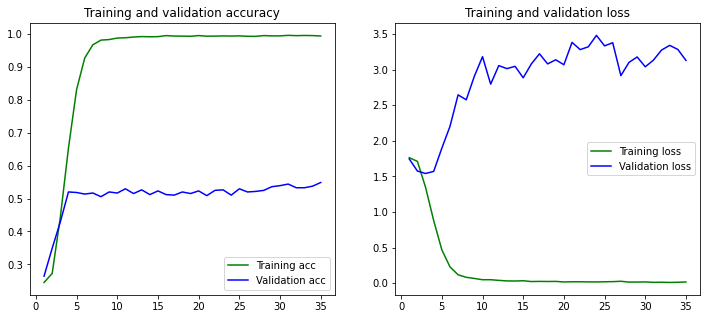

In [22]:
PlotGraph(history)

In [23]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.548799991607666


In [24]:
model.load_weights(checkpoint_filepath)

ValueError: Shapes (24754, 300) and (23087, 300) are incompatible

In [25]:
predict = model.predict(TEST)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

array([0, 1, 3, 3, 0, 0, 5, 1, 1, 1, 3, 3, 3, 0, 3, 4, 1, 3, 3, 1, 3, 5,
       3, 5, 2, 1, 4, 1, 3, 3, 4, 5, 1, 1, 1, 0, 5, 3, 0, 0, 3, 1, 3, 4,
       4, 1, 1, 5, 0, 0, 3, 0, 3, 3, 1, 5, 3, 2, 4, 3, 3, 4, 4, 0, 3, 1,
       5, 2, 0, 2, 1, 5, 1, 0, 3, 5, 1, 1, 1, 3, 1, 3, 1, 5, 1, 0, 5, 4,
       0, 3, 5, 1, 1, 4, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 5, 1, 3, 4,
       3, 1, 1, 0, 1, 1, 0, 5, 0, 5, 5, 0, 2, 1, 3, 1, 3, 3, 0, 4, 5, 3,
       1, 4, 5, 5, 0, 5, 3, 3, 1, 1, 2, 3, 1, 1, 5, 1, 5, 3, 5, 1, 0, 3,
       0, 2, 1, 3, 0, 0, 5, 3, 3, 3, 5, 1, 5, 2, 0, 5, 2, 3, 1, 5, 4, 1,
       0, 0, 4, 1, 1, 1, 3, 0, 3, 5, 1, 4, 1, 2, 2, 3, 2, 0, 1, 3, 3, 5,
       3, 1, 0, 0, 1, 1, 1, 1, 3, 3, 0, 5, 3, 2, 1, 3, 4, 1, 2, 0, 4, 3,
       0, 3, 1, 4, 2, 2, 1, 3, 1, 1, 3, 3, 4, 1, 3, 3, 3, 2, 3, 1, 1, 0,
       3, 3, 5, 5, 3, 0, 1, 0, 1, 4, 3, 0, 0, 4, 4, 0, 1, 2, 1, 1, 1, 1,
       1, 0, 3, 3, 5, 4, 5, 3, 4, 0, 1, 3, 0, 3, 5, 3, 1, 5, 4, 4, 4, 5,
       3, 3, 1, 0, 4, 5, 0, 0, 5, 3, 1, 1, 5, 1, 3,

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df["labels"], predict_class)
cm

array([[ 68,  31,   7,   5,   2,   1],
       [ 12,  68,   5,  11,  10,  13],
       [  9,  21,  23,   4,   3,  13],
       [  5,  28,   1, 112,  13,   6],
       [  3,  20,   1,  18,  25,   4],
       [  1,  20,   8,   1,   6,  47]], dtype=int64)

<AxesSubplot:>

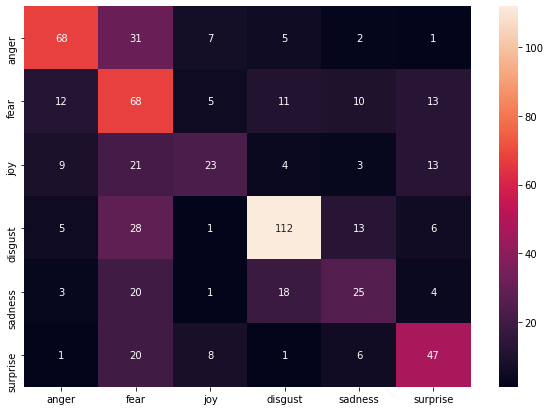

In [27]:
df_cm = pd.DataFrame(cm, index=["anger", "fear", "joy", "disgust", "sadness", "surprise"], columns=["anger", "fear", "joy", "disgust", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [28]:
from sklearn.metrics import classification_report

print(classification_report(test_df["labels"], predict_class, target_names =["anger", "fear", "joy", "disgust", "sadness", "surprise"]))

              precision    recall  f1-score   support

       anger       0.69      0.60      0.64       114
        fear       0.36      0.57      0.44       119
         joy       0.51      0.32      0.39        73
     disgust       0.74      0.68      0.71       165
     sadness       0.42      0.35      0.38        71
    surprise       0.56      0.57      0.56        83

    accuracy                           0.55       625
   macro avg       0.55      0.51      0.52       625
weighted avg       0.57      0.55      0.55       625

